In [1]:
#importing the required libraries
import numpy as np 
import requests
import json
import pandas as pd 
from datetime import datetime, date

In [2]:
# list of cities to be analyzed
cities = [
'Tokyo',
'Jakarta',
'Delhi',
'Manila',
'Seoul',
'Shanghai',
'Karachi',
'Beijing',
'New York',
'Guangzhou',
'Sao Paulo',
'Mexico City',
'Mumbai',
'Kyoto',
'Moscow',
'Dhaka',
'Cairo',
'Los Angeles',
'Bangkok',
'Kolkata',
]

In [3]:
# fetching the coordinates of the cities 
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='roboroaster')
coordinates = {}

for i in cities:
    location = geolocator.geocode(i)
    coordinates[i] = [location.latitude,location.longitude]
    

In [4]:
coordinates
    

{'Tokyo': [35.6828387, 139.7594549],
 'Jakarta': [-6.1753942, 106.827183],
 'Delhi': [28.6517178, 77.2219388],
 'Manila': [14.5948914, 120.9782618],
 'Seoul': [37.5666791, 126.9782914],
 'Shanghai': [31.2322758, 121.4692071],
 'Karachi': [24.8546842, 67.0207055],
 'Beijing': [39.906217, 116.3912757],
 'New York': [40.7127281, -74.0060152],
 'Guangzhou': [23.1301964, 113.2592945],
 'Sao Paulo': [-23.5506507, -46.6333824],
 'Mexico City': [19.4326296, -99.1331785],
 'Mumbai': [19.0785451, 72.878176],
 'Kyoto': [35.021041, 135.7556075],
 'Moscow': [55.7504461, 37.6174943],
 'Dhaka': [23.7644025, 90.389015],
 'Cairo': [30.0443879, 31.2357257],
 'Los Angeles': [34.0536909, -118.242766],
 'Bangkok': [13.7525438, 100.4934734],
 'Kolkata': [22.5414185, 88.35769124388872]}

In [18]:
# Creating functions to create the dataset of emmissions of each gas for each city
def df_maker(city,gas):
    url = f"https://api.v2.emissions-api.org/api/v2/{gas}/geo.json?point={coordinates[city][1]}&point={coordinates[city][0]}&begin=2019-02-10&end=2022-01-01&limit=1200&offset=1"
    r = requests.get(url)
    df = pd.DataFrame.from_dict(r.json())
    df = df.drop(columns='type')
    bn = pd.DataFrame(df.features.values.tolist())['properties']
    bn = pd.DataFrame.from_records(bn)
    bn = bn.rename(columns={
    "timestamp":"timestamp",
    "value" : f"{gas}_value"
    })
    bn['date'] = pd.to_datetime(bn['timestamp'],format="%Y-%m-%dT%H:%M:%S.%fZ").dt.date

    bn=bn.drop(columns='timestamp')
#     bn = bn.set_index('date')
    bn=bn.sort_values(by='date')
    return bn

    
    
    


In [19]:
# dataset compiler for each city 
def df_compiler(city):
    gases = ['carbonmonoxide','methane','ozone','nitrogendioxide']
    co = df_maker(city,gases[0])
    ch4 = df_maker(city,gases[1])
    o3 = df_maker(city,gases[2])
    no2 = df_maker(city,gases[3])
    df1 = pd.merge(co,ch4,on='date',how='outer')
    df2 = pd.merge(o3,no2,on='date',how='outer')
    df = pd.merge(df1,df2,on='date',how='outer')
    cols = list(df)
    cols.insert(0,cols.pop(cols.index('date')))
    date_col = df['date']
    df.drop(labels = ['date'],axis = 1,inplace = True)
    df.insert(0,'date',date_col)
    
    
    return df

In [20]:
tokyo = df_compiler('Tokyo')
jakarta = df_compiler('Jakarta')
tokyo

,date,carbonmonoxide_value,methane_value,ozone_value,nitrogendioxide_value
0,2019-02-10,0.043166,NaN,NaN,0.000049
1,2019-02-11,0.047945,NaN,NaN,0.000044
2,2019-02-12,0.035722,1865.038818,NaN,0.000108
3,2019-02-12,0.035722,1865.038818,NaN,0.000087
4,2019-02-12,0.036212,1865.038818,NaN,0.000108
...,...,...,...,...,...
1770,2021-11-10,NaN,NaN,NaN,0.000143
1771,2021-11-19,NaN,NaN,NaN,0.000133
1772,2021-11-21,NaN,NaN,NaN,0.000084
1773,2021-12-01,NaN,NaN,NaN,0.000111


In [8]:
tokyo.isna().sum()


date                        0
carbonmonoxide_value      465
methane_value            1529
ozone_value               241
nitrogendioxide_value     122
dtype: int64

In [12]:
tokyo['methane_value'].count()

246

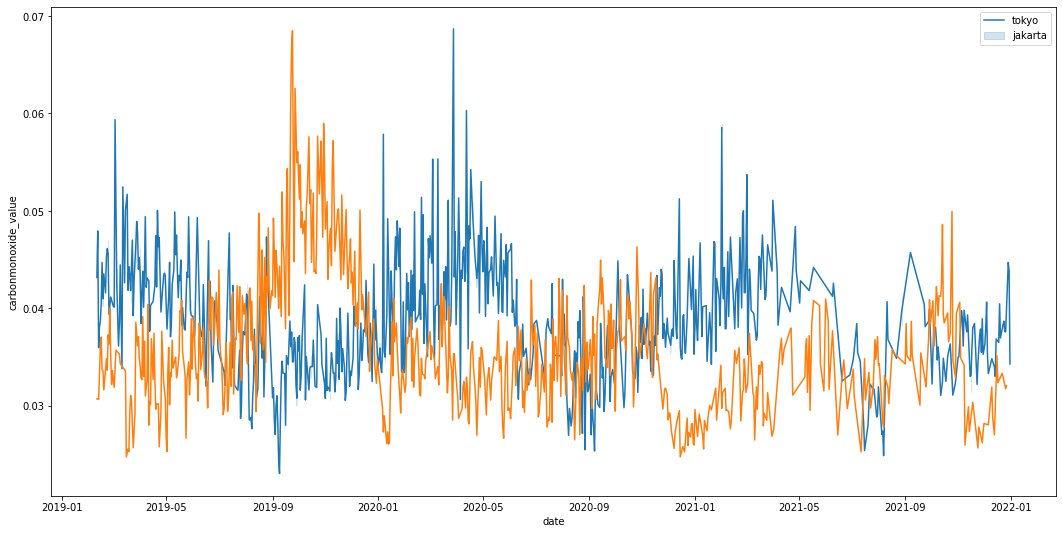

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,9))
sns.lineplot(x='date',y ='carbonmonoxide_value',data = tokyo)
sns.lineplot(x='date',y ='carbonmonoxide_value',data = jakarta)



plt.show()